In [3]:
from google.colab import files
uploaded = files.upload()


Saving Reconstructed_Matrix.csv to Reconstructed_Matrix.csv


In [4]:
import pandas as pd

# Load the uploaded reconstructed matrix
matrix_df = pd.read_csv("Reconstructed_Matrix.csv")

# Optional: Rename the index column if it's unnamed
if matrix_df.columns[0] != 'user_id':
    matrix_df.rename(columns={matrix_df.columns[0]: 'user_id'}, inplace=True)

# Set user_id as index (if needed)
matrix_df.set_index('user_id', inplace=True)

# Print shape and a preview of the data
print("✅ Matrix Loaded!")
print("Shape of matrix:", matrix_df.shape)
print("\n🔹 Preview:")
print(matrix_df.head())


✅ Matrix Loaded!
Shape of matrix: (838859, 1)

🔹 Preview:
              4496215.146
user_id                  
2.437160e+12  4330269.888
1.243750e+12  4483540.435
2.046590e+11  2326622.138
1.913770e+12  5809927.600
2.725080e+12  6267175.747


In [6]:
import numpy as np

# Reset index to bring user_id back as a column
matrix_df_reset = matrix_df.reset_index()

# Convert the wide matrix to long format: user_id, item_id, rating
long_df = matrix_df_reset.melt(id_vars=['user_id'], var_name='item_id', value_name='rating')

# Optional: Convert item_id to integer if needed (like from "item_0" to 0)
# Uncomment this if your item_id values look like "item_0", "item_1", etc.
# long_df['item_id'] = long_df['item_id'].str.extract('(\d+)').astype(int)

# Preview the transformed dataset
print("✅ Transformed Matrix Shape:", long_df.shape)
print("\n🔹 Sample rows:")
print(long_df.head())


✅ Transformed Matrix Shape: (838859, 3)

🔹 Sample rows:
        user_id      item_id       rating
0  2.437160e+12  4496215.146  4330269.888
1  1.243750e+12  4496215.146  4483540.435
2  2.046590e+11  4496215.146  2326622.138
3  1.913770e+12  4496215.146  5809927.600
4  2.725080e+12  4496215.146  6267175.747


In [7]:
from sklearn.model_selection import train_test_split

# Features: user_id and item_id
X = long_df[['user_id', 'item_id']]

# Target: rating
y = long_df['rating']

# Split the data — 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print sizes
print("✅ Train size:", len(X_train))
print("✅ Test size:", len(X_test))


✅ Train size: 671087
✅ Test size: 167772


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Get total number of unique users and items
num_users = long_df['user_id'].nunique()
num_items = long_df['item_id'].nunique()

# Define embedding dimension (you can tune this)
embedding_size = 64

# Input for user ID
user_input = keras.Input(shape=(1,), name='user_input')
user_embedding = layers.Embedding(input_dim=num_users + 1, output_dim=embedding_size, name='user_embedding')(user_input)
user_vec = layers.Flatten()(user_embedding)

# Input for item ID
item_input = keras.Input(shape=(1,), name='item_input')
item_embedding = layers.Embedding(input_dim=num_items + 1, output_dim=embedding_size, name='item_embedding')(item_input)
item_vec = layers.Flatten()(item_embedding)

# Concatenate user and item vectors
concat = layers.Concatenate()([user_vec, item_vec])

# MLP layers
x = layers.Dense(128, activation='relu')(concat)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Final output layer for rating prediction
output = layers.Dense(1, activation='linear', name='rating_output')(x)

# Define the model
mlp_model = keras.Model(inputs=[user_input, item_input], outputs=output)

# Compile the model
mlp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
mlp_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 64)          │     12,346,624 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 64)          │            128 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 64)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 64)             │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         16,512 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_output (Dense)     │ (None, 1)              │             33 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,373,633 (47.20 MB)

 Trainable params: 12,373,633 (47.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Convert to numpy arrays (required for TensorFlow)
import numpy as np

# Convert user_id to integers if they are not already
X_train['user_id'] = X_train['user_id'].astype(int)
X_test['user_id'] = X_test['user_id'].astype(int)

# Create a mapping for item_id to a continuous range starting from 1
# (0 is reserved for padding in Keras Embedding)
unique_item_ids = long_df['item_id'].unique()
item_id_mapping = {item_id: index + 1 for index, item_id in enumerate(unique_item_ids)}

# Apply the mapping to the training and testing data
X_train['item_id'] = X_train['item_id'].map(item_id_mapping).fillna(0).astype(int) # Fill NaN with 0 and cast to int
X_test['item_id'] = X_test['item_id'].map(item_id_mapping).fillna(0).astype(int)   # Fill NaN with 0 and cast to int


# Ensure user IDs are within the expected range
X_train['user_id'] = X_train['user_id'].clip(lower=0, upper=num_users)
X_test['user_id'] = X_test['user_id'].clip(lower=0, upper=num_users)

# Ensure item IDs are within the expected range
X_train['item_id'] = X_train['item_id'].clip(lower=0, upper=num_items)
X_test['item_id'] = X_test['item_id'].clip(lower=0, upper=num_items)

user_train = np.array(X_train['user_id'])
item_train = np.array(X_train['item_id'])
user_test = np.array(X_test['user_id'])
item_test = np.array(X_test['item_id'])

# Train the model
history = mlp_model.fit(
    [user_train, item_train], y_train,
    validation_data=([user_test, item_test], y_test),
    batch_size=1024,
    epochs=10,
    verbose=1

)

Epoch 1/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 130s 198ms/step - loss: 4700522938368.0000 - mae: 1816343.0000 - val_loss: 4699043921920.0000 - val_mae: 1816449.6250
Epoch 2/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 134s 186ms/step - loss: 4711039631360.0000 - mae: 1819008.1250 - val_loss: 4698292617216.0000 - val_mae: 1816419.2500
Epoch 3/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 143s 187ms/step - loss: 4692107591680.0000 - mae: 1814555.8750 - val_loss: 4698061406208.0000 - val_mae: 1816328.5000
Epoch 4/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 143s 189ms/step - loss: 4697960218624.0000 - mae: 1815071.5000 - val_loss: 4700019621888.0000 - val_mae: 1816698.6250
Epoch 5/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 156s 211ms/step - loss: 4705193820160.0000 - mae: 1817802.3750 - val_loss: 4706236628992.0000 - val_mae: 1817462.8750
Epoch 6/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 128s 195ms/step - loss: 4699830878208.0000 - mae: 1816842.3750 - val_loss: 4698232324096.0000 - val_mae: 1816347.6250
Epoch 7/10
656/656 ━━━━━━━━━━━━━━━━━━━━ 142s 196ms/s

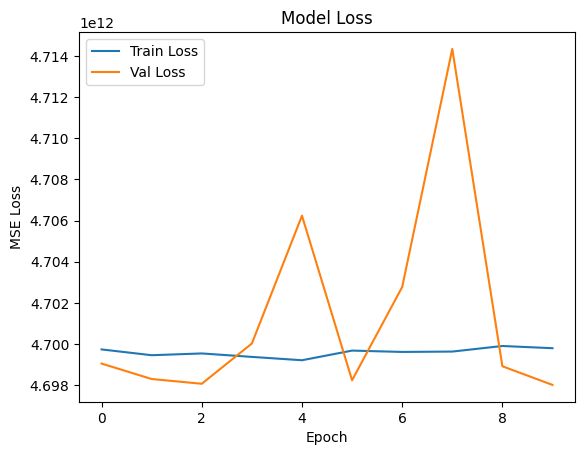

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


In [17]:
from google.colab import files
uploaded = files.upload()

Saving amazon_electronics_scores.csv to amazon_electronics_scores.csv


In [18]:
import pandas as pd

# Replace with your actual file name
df = pd.read_csv('amazon_electronics_scores.csv')

# Check the first few rows
df.head()


,User ID,Item ID,h_ij,d_ij,avg_score
0,AO94DHGC771SJ,0528881469,0.000000,0.312614,0.156307
1,AMO214LNFCEI4,0528881469,0.163296,0.259537,0.211416
2,A3N7T0DY83Y4IG,0528881469,0.698923,0.204728,0.451825
3,A1H8PY3QHMQQA0,0528881469,0.137781,0.146179,0.141980
4,A24EV6RXELQZ63,0528881469,0.000000,0.076943,0.038471


In [31]:
df['review_rank'] = df.groupby('Item ID').cumcount() + 1
df['n_prime'] = df.groupby('Item ID')['User ID'].transform('count')


In [32]:
df['z_ij'] = (1 / df['review_rank']**2)
df['sum_z'] = df.groupby('Item ID')['z_ij'].transform('sum')
df['most_ij'] = df['z_ij'] / df['sum_z']


In [33]:
df['q_ij'] = (df['n_prime'] - df['review_rank']) / (df['review_rank'] + 1e-8)  # Add small epsilon to avoid /0
df['sum_q'] = df.groupby('Item ID')['q_ij'].transform('sum')
df['top_ij'] = df['q_ij'] / df['sum_q']


In [34]:
alpha = 0.5
df['d_ij'] = alpha * df['top_ij'] + (1 - alpha) * df['most_ij']


In [35]:
df[['User ID', 'Item ID', 'most_ij', 'top_ij', 'd_ij']].head()


,User ID,Item ID,most_ij,top_ij,d_ij
0,AO94DHGC771SJ,0528881469,0.683242,0.623377,0.653309
1,AMO214LNFCEI4,0528881469,0.170810,0.233766,0.202288
2,A3N7T0DY83Y4IG,0528881469,0.075916,0.103896,0.089906
3,A1H8PY3QHMQQA0,0528881469,0.042703,0.038961,0.040832
4,A24EV6RXELQZ63,0528881469,0.027330,0.000000,0.013665


In [39]:
df.to_csv('reliability_scores.csv', index=False)
